<a href="https://colab.research.google.com/github/rammahayufitra/Microservices/blob/main/Task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Understanding the impact of varying the
batch size** 


In [3]:
from torchvision import datasets 
from torch.utils.data import Dataset, DataLoader 
import torch 
import torch.nn as nn 
import numpy as np 

device = "cuda" if torch.cuda.is_available() else "cpu"
print('device :', device)
!mkdir data 
!cd data 
!mkdir FMNIST 
data_folder = '/content/data/FMNIST'
fmnist = datasets.FashionMNIST(data_folder, download=False, train=True)
tr_images = fmnist.data 
tr_targets = fmnist.targets

# !zipped -r /content/data/FMNIST

device : cpu
mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘FMNIST’: File exists


In [4]:
val_fmnist = datasets.FashionMNIST(data_folder, download=False, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

In [5]:
class FMNISTDataset(Dataset):
  def __init__(self,x,y):
    x = x.float()/255 
    x = x.view(-1,28*28)
    self.x, self.y = x, y 
  def __getitem__(self, ix):
    x, y = self.x[ix], self.y[ix]
    return x.to(device), y.to(device)
  def __len__(self):
    return len(self.x)

    

In [6]:
def get_data():
  train = FMNISTDataset(tr_images, tr_targets)
  trn_dl = DataLoader(train, batch_size=32, shuffle=True)
  val = FMNISTDataset(val_images, val_targets) 
  val_dl = DataLoader(val, batch_size=len(val_images), shuffle=False)
  return trn_dl, val_dl

In [7]:
from torch.optim import SGD,Adam
def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-2)
    return model, loss_fn, optimizer

In [8]:
def train_batch(x,y,model,opt, loss_fn):
  model.train() 
  prediction = model(x)
  batch_loss = loss_fn(prediction, y)
  batch_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  return batch_loss.item() 

In [9]:
def accuracy(x, y, model):
    model.eval()
    # since there's no need for updating weights, we might 
    # as well not compute the gradients
    with torch.no_grad():
        # get the prediction matrix for a tensor of `x` images
        prediction = model(x)
    # compute if the location of maximum in each row coincides 
    # with ground truth
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()



In [12]:
@torch.no_grad()
def val_loss(x,y,model):
  prediction = model(x)
  val_loss = loss_fn(prediction, y)
  return val_loss.item() 

In [13]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()



In [14]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss) 
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)


0
1
2
3
4


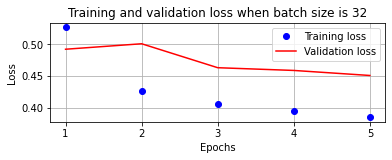

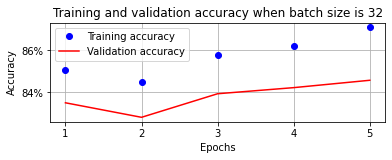

In [15]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()



# batch size of 10000

In [17]:
def get_data(): 
    train = FMNISTDataset(tr_images, tr_targets) 
    trn_dl = DataLoader(train, batch_size=10000, shuffle=True)
    val = FMNISTDataset(val_images, val_targets) 
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=False)
    return trn_dl, val_dl


In [18]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()


In [19]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss) 
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


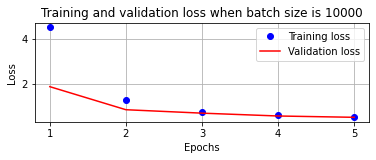

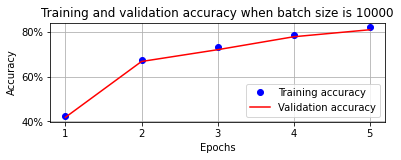

In [20]:


epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss when batch size is 10000')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy when batch size is 10000')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

